In [1]:
#Adds higher directory to path, so we can access /ATS
import sys
sys.path.append("../")

from ATS.API import update_Cal_IPC
from ATS.general import *
from ATS.QAQC import *

from arcgis.features import *
from arcgis.geometry import *
import pandas as pd

# Set the DataFram in pandas to show all columns and 1000 rows. Display plots inline
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)

2022-02-07 20:06:52.354927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-07 20:06:52.354966: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
service_id = 'f6194c9524bf455d88cab06703e767a5'

<Item title:"SAC_NNIP" type:Feature Layer Collection owner:Anooshi>
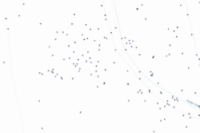

In [3]:
#load data
output = arcGIS_data_load(service_id)

monitoring = output['table2']
monitoring_obs = output['table3']
feature_service = output['feature_service']

# Update Cal_IPC_Rating column

<Item title:"SAC_NNIP" type:Feature Layer Collection owner:Anooshi>
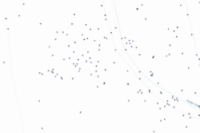

Current Plant Species List file location:
/home/user/SAC/Script Support Files/SAC Master Plant Species List 20191114.xlsx
Current Sheet Name:
Year 5 Plant Species List


FileNotFoundError: [Errno 2] No such file or directory: '/home/user/SAC/Script Support Files/SAC Master Plant Species List 20191114.xlsx'

In [4]:
update_Cal_IPC(service_id,'Cal_IPC_Rating','Species_Sci',layer=0)

# Update NNIP Hits columns - from monitoring observation table


In [ ]:
# Merge monitoring and monitoring observations (quads)
rQuads = monitoring.merge(monitoring_obs, left_on='GlobalID', right_on='Ref_to_Monitoring', how='inner')
rQuads = rQuads.drop(columns=['Comments', 'Cont_In_Single_Hab', 'GlobalID_x', 'Int_Dist',
       'MMU_max_cover',
       'Patch_Len', 'Patch_Shape', 'Patch_Size', 'Patch_Wid',  'Ref_to_Points', 'Surveyor_1',
       'Surveyor_2', 'Total_Cover', 'GlobalID_y', 'OBJECTID_y',
        'Ref_to_Monitoring','Q1_NNIP_Hits','Q2_NNIP_Hits','Q3_NNIP_Hits'])
rQuads

In [6]:
#Subset quad point data to only quads that met MMU and had target NNIP
rQuads_sub = rQuads.loc[(rQuads.Patch_Det=='GreaterThanMMU') & (rQuads.Score=='Target NNIP'),:]

In [7]:
#Tally NNIP hits by object ID (site) and Quad
scores = pd.DataFrame(rQuads_sub.groupby(['OBJECTID_x','Quadrat']).Score.count())
scores = scores.rename(columns={'Score':'NNIPhits'})
scores.reset_index(inplace=True)
scores

,OBJECTID_x,Quadrat,NNIPhits
0,82,1,5
1,82,2,5
2,89,1,14
3,89,2,12
4,90,1,15
5,90,2,8


In [8]:
#Update records
# Get all records
quad_obs = feature_service.tables[2].query(return_all_records=True)

edits = []

#loop through each feature
for feature in quad_obs.features:
    
    obj_id = feature.attributes['OBJECTID']
    update_flag = False

    if obj_id in scores.OBJECTID_x.tolist():
        Q1_hits = scores.loc[(scores.OBJECTID_x==obj_id) & (scores.Quadrat==1),'NNIPhits'].values
        Q2_hits = scores.loc[(scores.OBJECTID_x==obj_id) & (scores.Quadrat==2),'NNIPhits'].values
        Q3_hits = scores.loc[(scores.OBJECTID_x==obj_id) & (scores.Quadrat==3),'NNIPhits'].values

        if Q1_hits.any():
            feature.attributes['Q1_NNIP_Hits'] = Q1_hits[0]
            update_flag = True
        if Q2_hits.any():
            feature.attributes['Q2_NNIP_Hits'] = Q2_hits[0]
            update_flag = True
        if Q3_hits.any():
            feature.attributes['Q3_NNIP_Hits'] = Q3_hits[0]
            update_flag = True


    #if an change was made, update through API
    if update_flag:
        edits.append(feature)

#send updates if edit was made
if edits:
    result = feature_service.tables[2].edit_features(updates=edits)

    #Check if update was successful
    fail_flag = False
    for item in result['updateResults']:
        if not item['success']:
            fail_flag = True
            print('Could not update feature, Object ID: ',item['objectId'])

    if not fail_flag:
        print('Successfully updated features')
        
else:
    print('No edits made')

Successfully updated features


# Update % Cover column

In [9]:
#Update records
# Get all records
quad_obs = feature_service.tables[2].query(return_all_records=True)

edits = []

#loop through each feature
for feature in quad_obs.features:
    
    obj_id = feature.attributes['OBJECTID']
    update_flag = False

    Q1 = feature.attributes['Q1_NNIP_Hits']
    Q2 = feature.attributes['Q2_NNIP_Hits']
    Q3 = feature.attributes['Q3_NNIP_Hits']
    
    # 3 quads used
    if isinstance(Q1, int) & isinstance(Q2, int) & isinstance(Q3, int):
        feature.attributes['Total_Cover'] = (Q1+Q2+Q3)/(32*3)*100

    elif isinstance(Q1, int) & isinstance(Q2, int) & (Q3 is None):
        feature.attributes['Total_Cover'] =(Q1+Q2)/(32*2)*100
        
    elif isinstance(Q1, int) & (Q2 is None) & (Q3 is None):
        feature.attributes['Total_Cover'] = Q1/(32*3)*100
        
    elif (Q1 is None) & (Q2 is None) & (Q3 is None):
        feature.attributes['Total_Cover'] = None
    
    else:
        print('ERROR: data type of quad hits is not None or Int. ObjectID: ', obj_id)

    #add to edit list
    edits.append(feature)

#send updates 

result = feature_service.tables[2].edit_features(updates=edits)

#Check if update was successful
fail_flag = False
for item in result['updateResults']:
    if not item['success']:
        fail_flag = True
        print('Could not update feature, Object ID: ',item['objectId'])

if not fail_flag:
    print('Successfully updated features')

Successfully updated features


# Load data, subset, merge

<Item title:"SAC_NNIP" type:Feature Layer Collection owner:Anooshi>
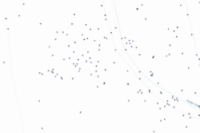

In [5]:
#load data after column updates
output = arcGIS_data_load(service_id)

points = output['data0']
monitoring = output['table2']
feature_service = output['feature_service']

In [6]:
# Merge related table and feature layer
data = points.merge(monitoring, left_on='GlobalID', right_on='Ref_to_Points', how='inner')
data = data.drop(columns=['Ref_to_Points'])
data = data.rename(columns={'GlobalID_y':'Record_GlobalID','OBJECTID_x':'Point_ObjectID', 'OBJECTID_y':'Record_ObjectID'})


In [7]:
# Subset by year
sYear = input("Start Year? (YYYY)")
sub = year_subset(data, sYear)

Start Year? (YYYY) 2020

Analysis for 2020-10-01 07:00 UTC to 2021-10-01 07:00 UTC
Entries in Subset: 42


# QAQC

In [8]:
QAQC_whitespace(data, exclude_cols=['Comments','Comments_y'], objectID=['Record_ObjectID'])



Analysis for: Record_GlobalID
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Cont_In_Single_Hab
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: SHAPE
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Surveyor_1
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: GlobalID_x
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Cover
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Patch_Det
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Int_Dist
No \xa0 characters found
No double spaces found
No triple spaces found
No tra

In [14]:
find_blank_entries(data, exclude_cols=['Int_Dist','Cover','Patch_Shape','Cont_In_Single_Hab',
'Patch_Det','Comments_x','Comments_y','Q1_NNIP_Hits','Q2_NNIP_Hits','Q3_NNIP_Hits','MMU_max_cover','ESRIGNSS_H_RMS','Patch_Len','ESRIGNSS_AVG_H_RMS','ESRIGNSS_RECEIVER','Patch_Wid'])

No blank Cal_IPC_Rating
No blank Observation_Date
No blank Record_ObjectID
Blank Surveyor_2 entrie(s) exist!


,Point_ObjectID,Species_Sci,Cover,GlobalID_x,Cal_IPC_Rating,BHR_Site,Deprecated,Comments_x,ESRIGNSS_RECEIVER,ESRIGNSS_H_RMS,ESRIGNSS_AVG_H_RMS,SHAPE,Record_ObjectID,Observation_Date,Surveyor_1,Surveyor_2,Patch_Shape,Patch_Len,Patch_Wid,Patch_Size,Patch_Det,MMU_max_cover,Comments_y,Cont_In_Single_Hab,Int_Dist,Total_Cover,Record_GlobalID,Q1_NNIP_Hits,Q2_NNIP_Hits,Q3_NNIP_Hits
136,3111,Lepidium latifolium,None,88ae2293-25f7-4ade-853f-8aaa09bdf4a7,High,SAC,Active,New 2020,GNSS:84087,NaN,1.557211,"{'x': 6182035.084279227, 'y': 2036711.0838494373, 'spatialReferenc...",139,2021-08-10 18:34:30,Kurt Lutz,None,Linear,NaN,NaN,4,LessThanMMU,0.0,Single individual next to hanging QUAG branch.,Yes,Homogeneous,NaN,cf2b0fda-40ed-46df-be19-5e882981d051,NaN,NaN,NaN


Blank Total_Cover entrie(s) exist!


In [16]:
print('Patches less than MMU without aprox max cover value:')
data.loc[(data.Patch_Det == 'LessThanMMU') & (data.MMU_max_cover.isna()),:]

Patches less than MMU without aprox max cover value:


,Point_ObjectID,Species_Sci,Cover,GlobalID_x,Cal_IPC_Rating,BHR_Site,Deprecated,Comments_x,ESRIGNSS_RECEIVER,ESRIGNSS_H_RMS,ESRIGNSS_AVG_H_RMS,SHAPE,Record_ObjectID,Observation_Date,Surveyor_1,Surveyor_2,Patch_Shape,Patch_Len,Patch_Wid,Patch_Size,Patch_Det,MMU_max_cover,Comments_y,Cont_In_Single_Hab,Int_Dist,Total_Cover,Record_GlobalID,Q1_NNIP_Hits,Q2_NNIP_Hits,Q3_NNIP_Hits


/home/user/SAC/../ATS/QAQC.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plt_r,plt_c].set_xticklabels(r['DateString'], rotation='vertical')


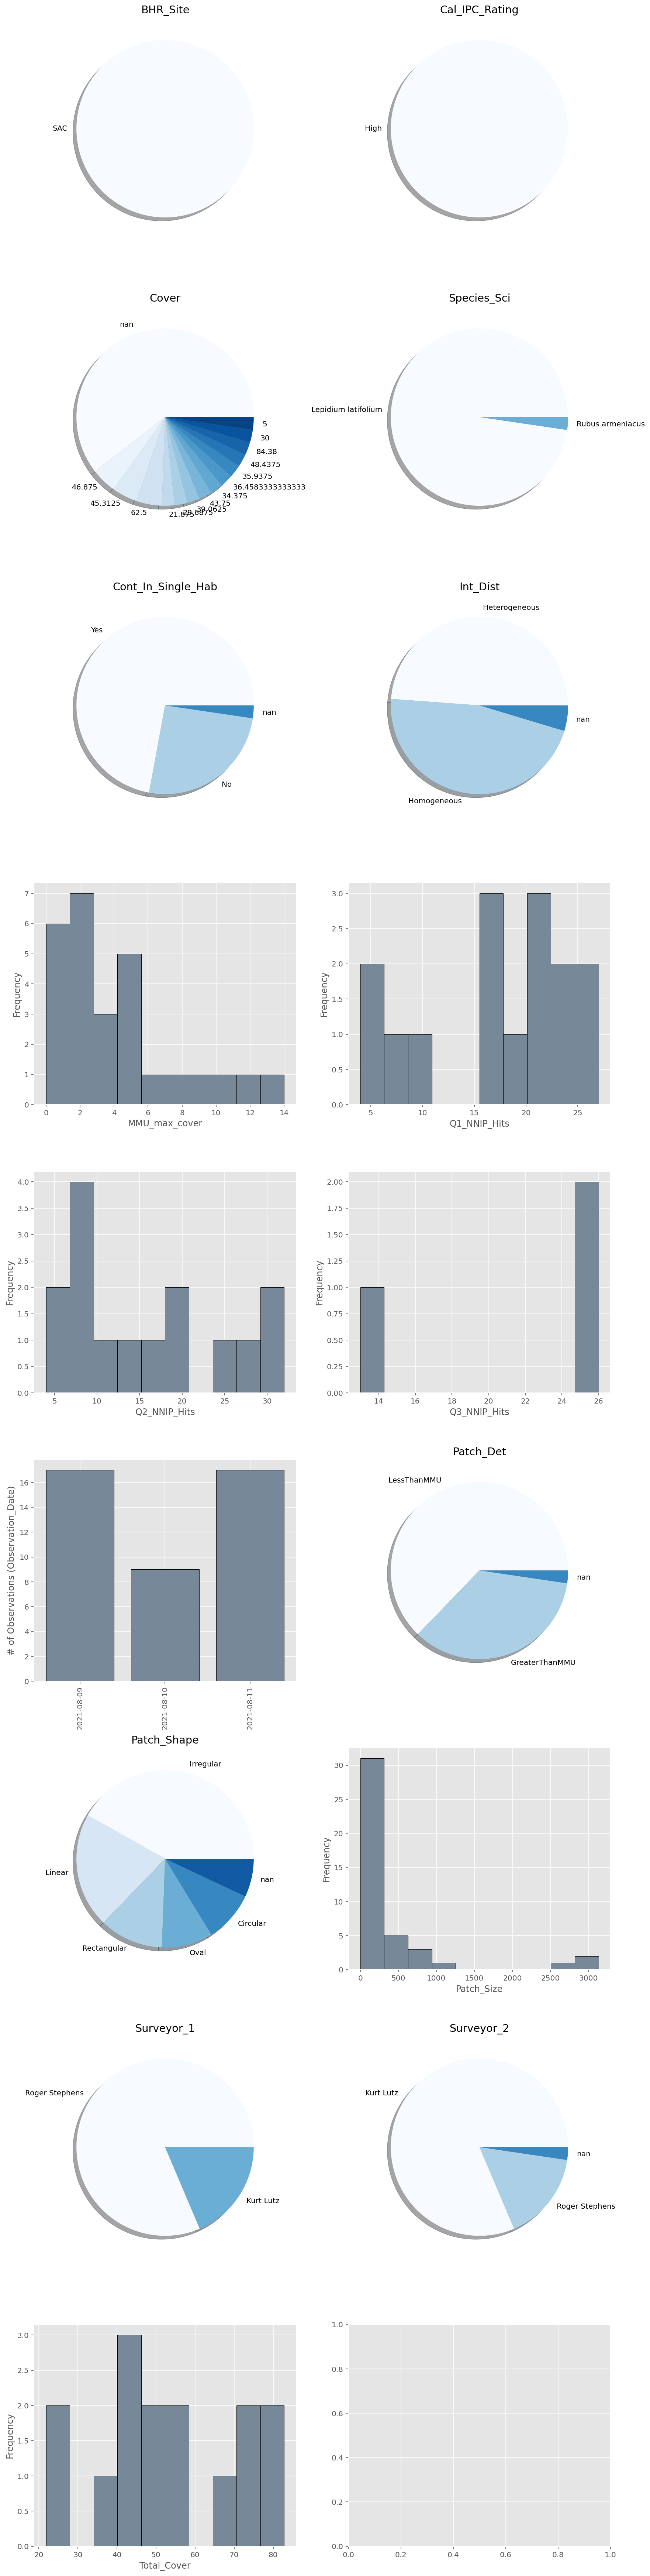

In [17]:
QAQC_plot(sub,['BHR_Site', 'Cal_IPC_Rating', 'Cover', 'Species_Sci',
       'Cont_In_Single_Hab',  'Int_Dist',
       'MMU_max_cover', 'Q1_NNIP_Hits',
       'Q2_NNIP_Hits', 'Q3_NNIP_Hits',
        'Observation_Date', 'Patch_Det', 'Patch_Shape',
       'Patch_Size', 'Surveyor_1', 'Surveyor_2',
       'Total_Cover'])

Patch_Size  Outlier: True
See Outlier Entries Below:


,Point_ObjectID,Species_Sci,Cover,GlobalID_x,Cal_IPC_Rating,BHR_Site,Deprecated,Comments_x,ESRIGNSS_RECEIVER,ESRIGNSS_H_RMS,ESRIGNSS_AVG_H_RMS,SHAPE,Record_ObjectID,Observation_Date,Surveyor_1,Surveyor_2,Patch_Shape,Patch_Len,Patch_Wid,Patch_Size,Patch_Det,MMU_max_cover,Comments_y,Cont_In_Single_Hab,Int_Dist,Total_Cover,Record_GlobalID,Q1_NNIP_Hits,Q2_NNIP_Hits,Q3_NNIP_Hits,Patch_Size_Outlier
33,10,Lepidium latifolium,45.3125,9eeb5149-3b71-4247-b845-3f3d0991aae7,High,SAC,Active,None,None,NaN,NaN,"{'x': 6182086.82727451, 'y': 2036632.6213311695, 'spatialReference...",147,2021-08-10 20:30:39,Roger Stephens,Kurt Lutz,Irregular,NaN,NaN,2635,GreaterThanMMU,NaN,All neighboring polygons now have merged into one large patch form...,No,Homogeneous,42.708333,337e274e-81cb-4cca-908f-5d00239936ff,23.0,5.0,13.0,True
37,11,Lepidium latifolium,62.5,8462f680-5d98-49e9-9b63-70190bdb4036,High,SAC,Active,None,None,NaN,NaN,"{'x': 6182036.507618981, 'y': 2036585.0896467627, 'spatialReferenc...",135,2021-08-09 20:08:12,Roger Stephens,Kurt Lutz,Rectangular,NaN,NaN,941,GreaterThanMMU,NaN,"Treated patch, most plants dying. Partially within SW area, but mo...",No,Homogeneous,45.312500,cf182e9b-5993-4511-8bc7-a45db2540e13,21.0,8.0,NaN,True
56,16,Lepidium latifolium,45.3125,a90bf14e-1fde-4b2a-a200-479b8876f954,High,SAC,Active,None,None,NaN,NaN,"{'x': 6182022.312889218, 'y': 2036684.1575916407, 'spatialReferenc...",145,2021-08-10 18:49:51,Roger Stephens,Kurt Lutz,None,NaN,NaN,903,GreaterThanMMU,NaN,Patch stratified into different densities.,Yes,Heterogeneous,25.000000,314f64ee-f709-42d9-bc39-e5c64f5b80f0,5.0,11.0,NaN,True
62,18,Lepidium latifolium,36.4583333333333,d881dc81-0666-40e9-ab1a-f5770b537e31,High,SAC,Active,None,None,NaN,NaN,"{'x': 6181912.847885057, 'y': 2036692.6100025624, 'spatialReferenc...",141,2021-08-10 17:52:05,Roger Stephens,Kurt Lutz,Irregular,NaN,NaN,3010,GreaterThanMMU,NaN,Merged three patches and one point into one patch. Patch size of t...,Yes,Homogeneous,53.125000,f4983925-d3e6-4fb7-9fd3-2a4ed54707bc,8.0,18.0,25.0,True
110,34,Lepidium latifolium,62.5,c9ef6f46-6e28-4695-b3ac-7f396e6f8a27,High,SAC,Active,None,None,NaN,NaN,"{'x': 6181780.160814464, 'y': 2037339.038499728, 'spatialReference...",163,2021-08-11 20:57:33,Roger Stephens,Kurt Lutz,Irregular,NaN,NaN,3135,GreaterThanMMU,NaN,"Stratified into three differing habitat sections (sunny section, c...",No,Heterogeneous,67.708333,8f9634da-ddb7-48d0-aada-9e3cf2833a03,22.0,17.0,26.0,True


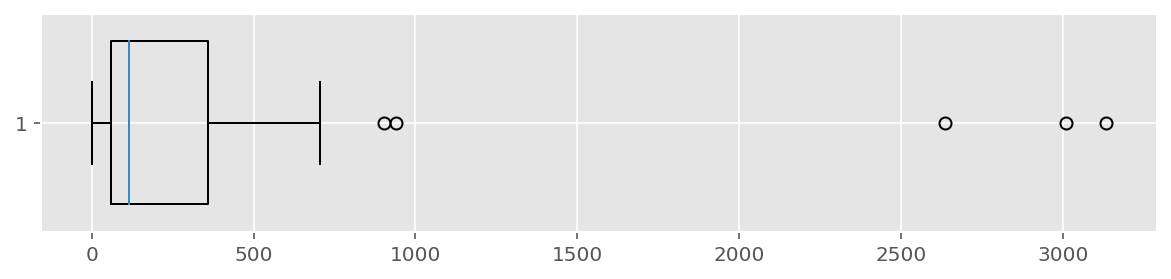

In [18]:
 outlier = find_outlier(sub,['Patch_Size'])

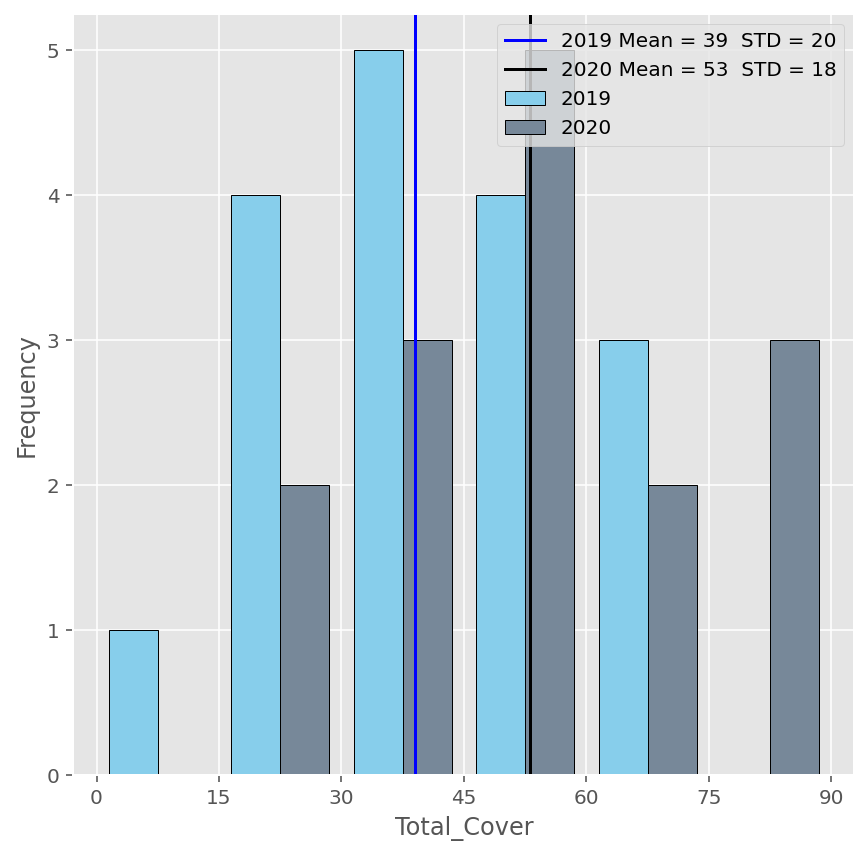

In [20]:
compare_years_continuous(data, 'Total_Cover', '2019', '2020', 15)

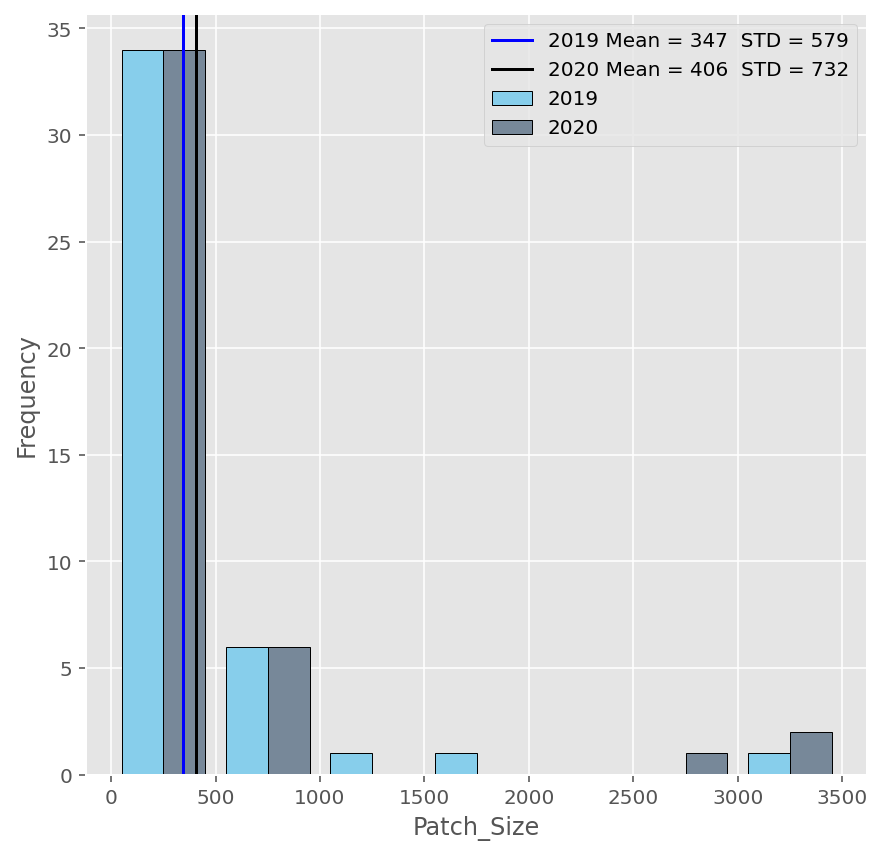

In [21]:
compare_years_continuous(data,'Patch_Size', '2019', '2020', 500)

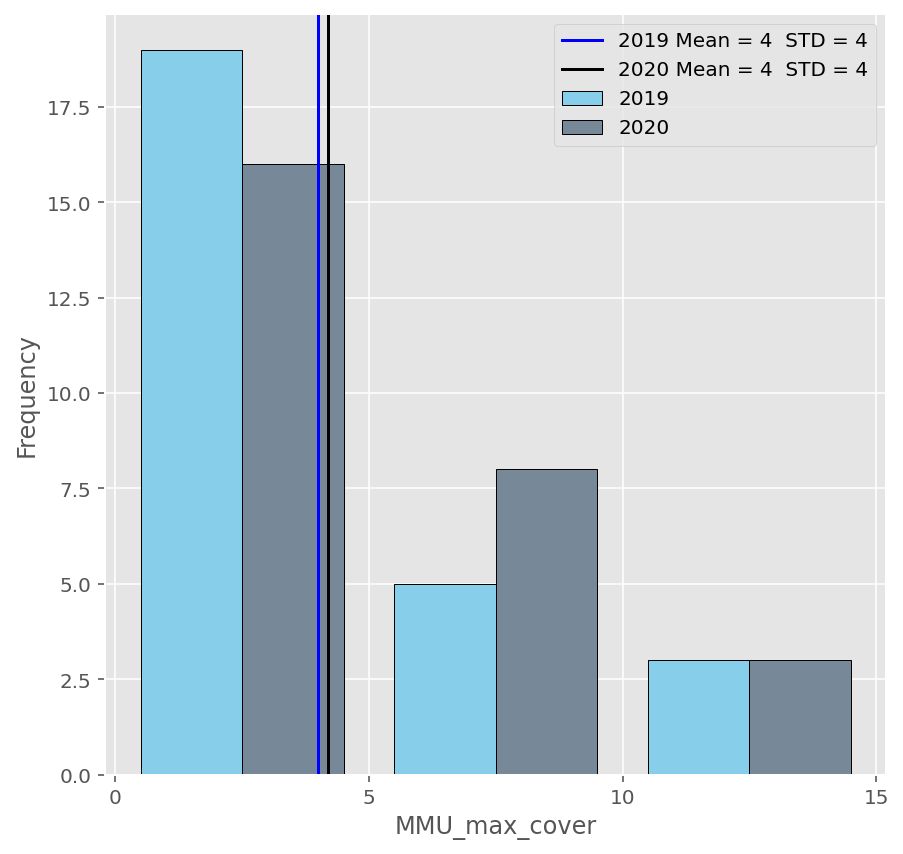

In [22]:
compare_years_continuous(data,'MMU_max_cover', '2019', '2020', 5)

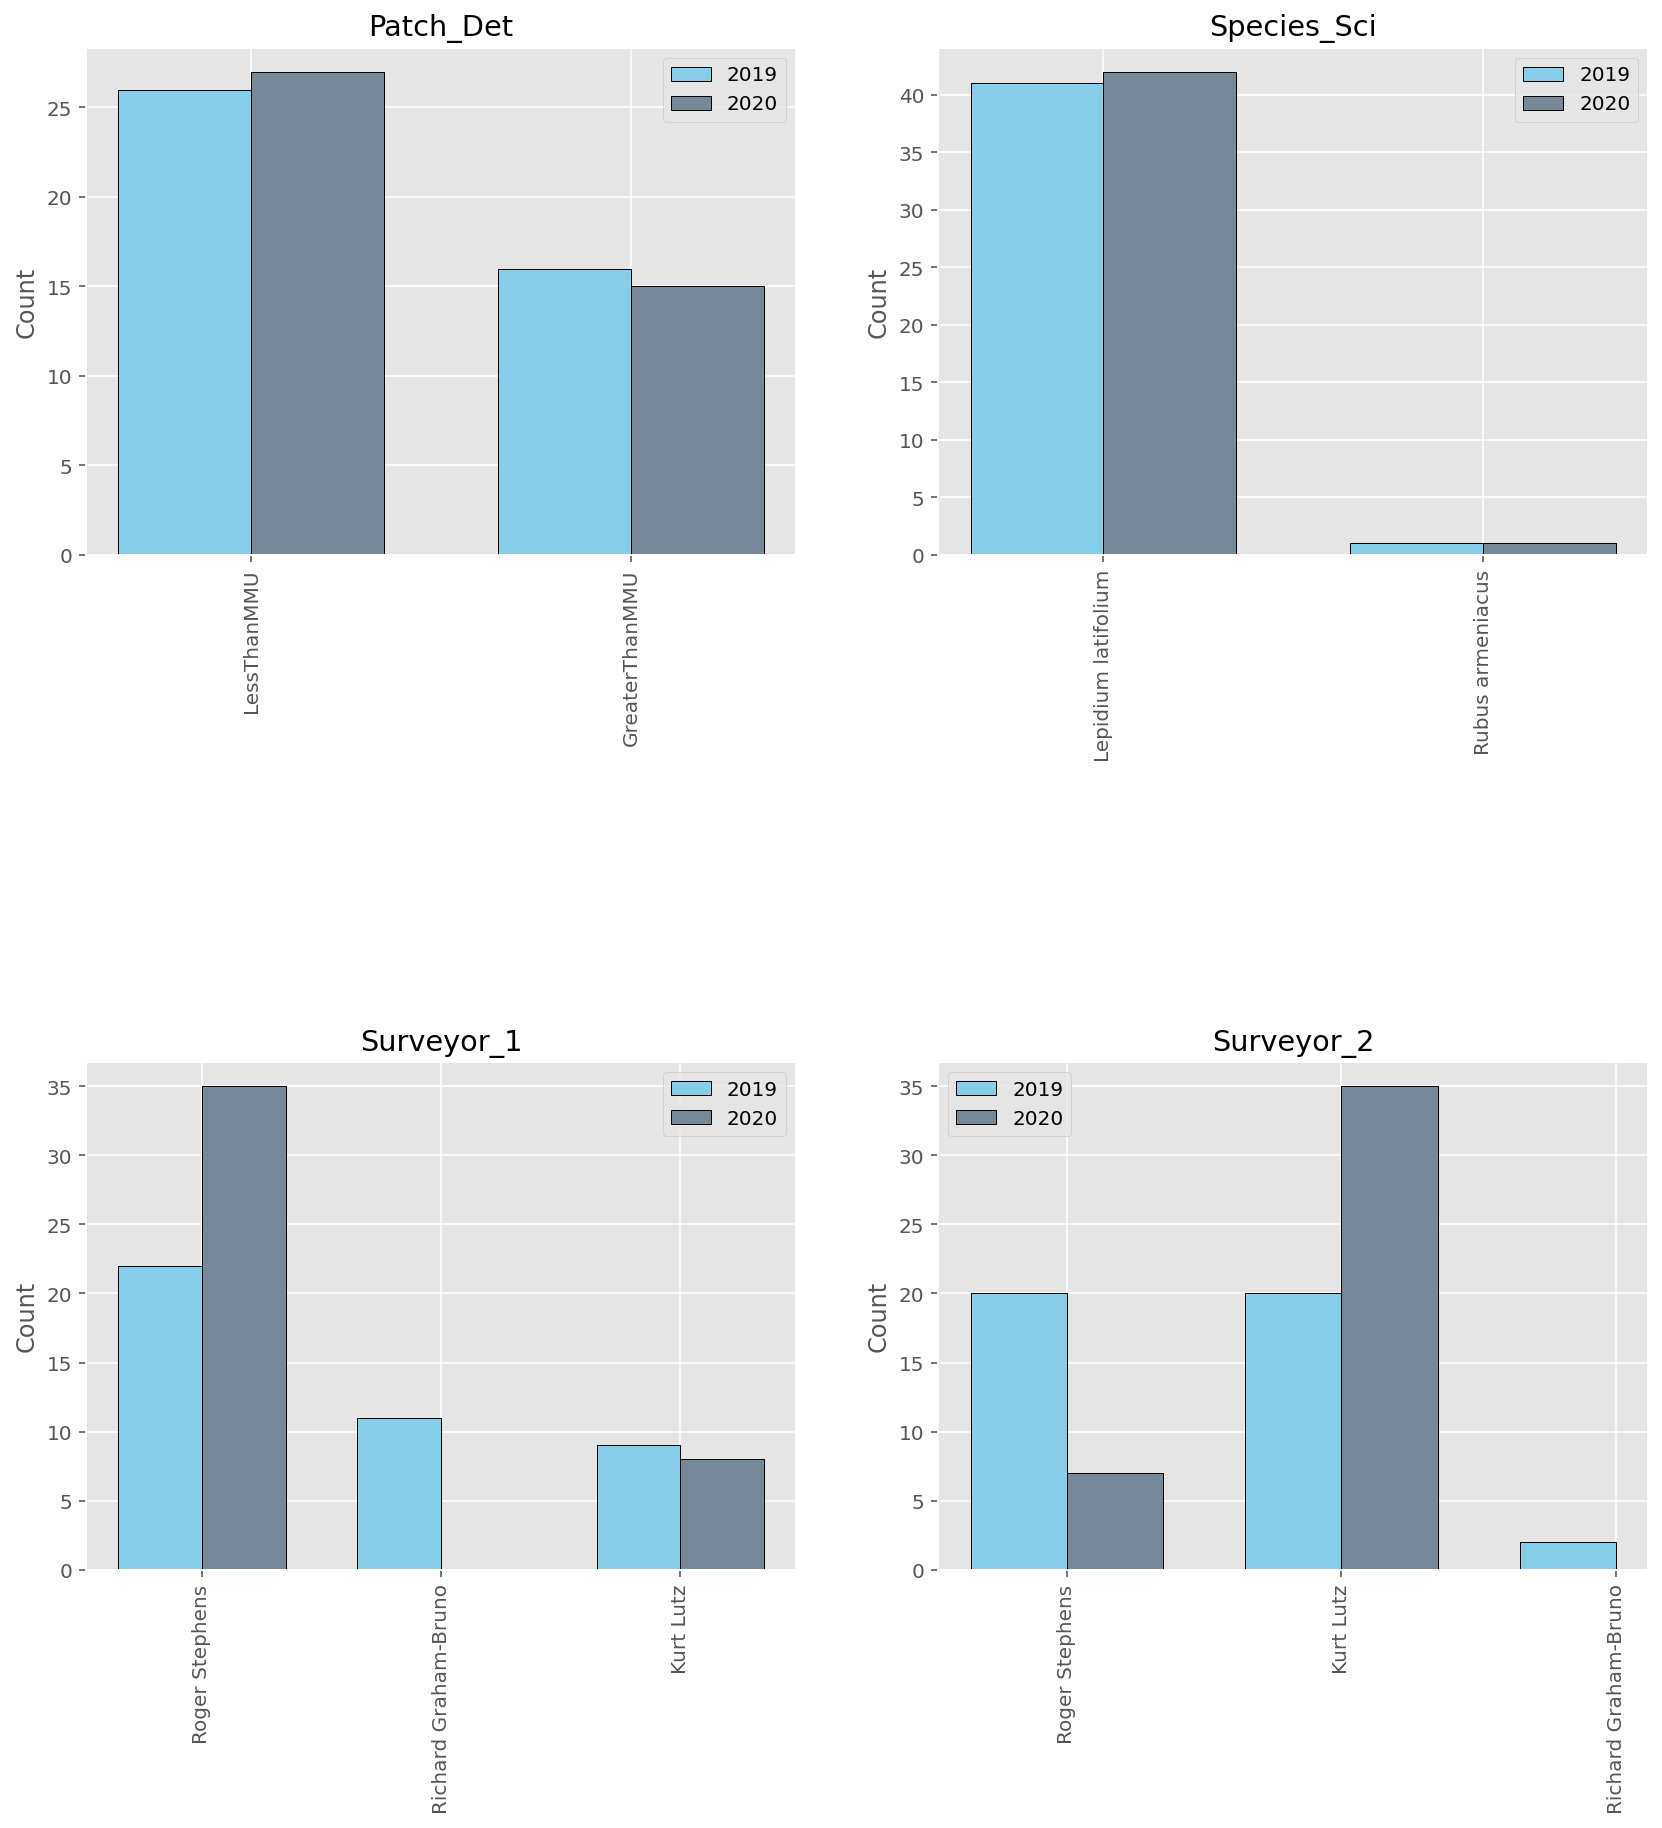

In [23]:
cols = ['Patch_Det','Species_Sci','Surveyor_1','Surveyor_2']
compare_years_catagorical(data, cols,'2019','2020')

In [24]:
print('Both of the following statements should equal False\n')
print('Quad data missing for Greater Than MMU patches:', not sub.loc[sub.Patch_Det == 'GreaterThanMMU','Q1_NNIP_Hits'].any())
print('Quad data for Less Than MMU patches:', sub.loc[sub.Patch_Det != 'GreaterThanMMU','Q1_NNIP_Hits'].any())

Both of the following statements should equal False

Quad data missing for Greater Than MMU patches: False
Quad data for Less Than MMU patches: False


In [25]:
QAQC_attachment_filenames(feature_service)


No attachments for layer/table Points


Found mislabeled photo attachement(s):
NNIP_Management
Object ID: 2  Current Name:  Photo 1.jpg


Object ID: 37  Current Name:  Photo 1.jpg


Object ID: 68  Current Name:  Photo 1.jpg
Object ID: 69  Current Name:  Photo 1.jpg
Object ID: 70  Current Name:  Photo 1.jpg


Object ID: 89  Current Name:  Photo 1.jpg


Object ID: 144  Current Name:  Photo 1.jpg


Object ID: 152  Current Name:  Photo 1.jpg


Object ID: 291  Current Name:  Photo 2.jpg
Object ID: 291  Current Name:  Photo 1.jpg
Object ID: 292  Current Name:  Photo 2.jpg
Object ID: 292  Current Name:  Photo 1.jpg


Object ID: 293  Current Name:  Photo 1.jpg
Object ID: 294  Current Name:  Photo 1.jpg
Object ID: 295  Current Name:  Photo 1.jpg


Object ID: 296  Current Name:  Photo 1.jpg
Object ID: 297  Current Name:  Photo 1.jpg


Object ID: 302  Current Name:  Photo 1.jpg


Object ID: 315  Current Name:  Photo 1.jpg


Object ID: 337  Current Name:  Photo 1.jpg
Object ID: 337  Current Name:  Photo 4.jpg
Object ID: 337  Current Name:  Photo 3.jpg


Object ID: 346  Current Name:  Photo 1.jpg


Object ID: 347  Current Name:  Photo 1.jpg
Object ID: 348  Current Name:  Photo 1.jpg
Object ID: 349  Current Name:  Photo 1.jpg


Object ID: 582  Current Name:  Photo 1.jpg


Object ID: 590  Current Name:  Photo 1.jpg


Object ID: 625  Current Name:  Photo 1.jpg


Object ID: 641  Current Name:  Photo 1.jpg


Object ID: 696  Current Name:  Photo 1.jpg


Object ID: 761  Current Name:  Photo 1.jpg


Object ID: 915  Current Name:  Photo 1.jpg


Object ID: 954  Current Name:  Photo 1.jpg


Object ID: 992  Current Name:  Photo 1.jpg


Object ID: 1046  Current Name:  Photo 1.jpg


Object ID: 1060  Current Name:  Photo 1.jpg


Object ID: 1088  Current Name:  Photo.jpg


Object ID: 1144  Current Name:  Photo 1.jpg


Object ID: 1213  Current Name:  Photo 1.jpg


Object ID: 1219  Current Name:  Photo 1.jpg


Object ID: 1225  Current Name:  Photo 1.jpg


Object ID: 1471  Current Name:  Photo 1.jpg
Object ID: 1472  Current Name:  Photo 1.jpg


Object ID: 1474  Current Name:  Photo 1.jpg
Object ID: 1475  Current Name:  Photo 1.jpg
Object ID: 1475  Current Name:  Photo 3.jpg
Object ID: 1475  Current Name:  Photo 2.jpg


Object ID: 1476  Current Name:  Photo 1.jpg
Object ID: 1477  Current Name:  Photo 1.jpg


Object ID: 1478  Current Name:  Photo 1.jpg
Object ID: 1478  Current Name:  Photo 2.jpg
Object ID: 1479  Current Name:  Photo 2.jpg
Object ID: 1479  Current Name:  Photo 1.jpg
Object ID: 1480  Current Name:  Photo 1.jpg


Object ID: 1481  Current Name:  Photo 1.jpg
Object ID: 1482  Current Name:  Photo 1.jpg


Object ID: 1483  Current Name:  Photo 1.jpg
Object ID: 1484  Current Name:  Photo 1.jpg
Object ID: 1484  Current Name:  Photo 3.jpg
Object ID: 1484  Current Name:  Photo 2.jpg
Object ID: 1484  Current Name:  Photo 4.jpg


Object ID: 1485  Current Name:  Photo 2.jpg
Object ID: 1485  Current Name:  Photo 1.jpg
Object ID: 1485  Current Name:  Photo 3.jpg
Object ID: 1486  Current Name:  Photo 1.jpg
Object ID: 1486  Current Name:  Photo 2.jpg


Object ID: 1728  Current Name:  Photo 1.jpg


Object ID: 1753  Current Name:  Photo 1.jpg


Object ID: 1791  Current Name:  Photo 1.jpg
Object ID: 1791  Current Name:  Photo 3.jpg
Object ID: 1791  Current Name:  Photo 2.jpg


Object ID: 1794  Current Name:  Photo 1.jpg


Object ID: 1808  Current Name:  Photo 1.jpg


Object ID: 1826  Current Name:  Photo 1.jpg


Object ID: 1834  Current Name:  Photo 2.jpg
Object ID: 1834  Current Name:  Photo 1.jpg


Object ID: 1934  Current Name:  Photo 1.jpg


Object ID: 1978  Current Name:  Photo 1.jpg


Object ID: 2021  Current Name:  Photo 1.jpg


Object ID: 2104  Current Name:  Photo 1.jpg


Object ID: 2106  Current Name:  Photo 1.jpg


Object ID: 2109  Current Name:  Photo 1.jpg


Object ID: 2116  Current Name:  Photo 1.jpg


Object ID: 2121  Current Name:  Photo 1.jpg


Object ID: 2166  Current Name:  Photo 1.jpg


Object ID: 2170  Current Name:  Photo 1.jpg


Object ID: 2186  Current Name:  Photo 1.jpg


Object ID: 2227  Current Name:  Photo 1.jpg
Object ID: 2228  Current Name:  Photo 1.jpg


Object ID: 2229  Current Name:  Photo 1.jpg


Object ID: 2293  Current Name:  Photo 1.jpg


Object ID: 2591  Current Name:  Photo 1.jpg


Object ID: 2689  Current Name:  Photo 1.jpg


Object ID: 2697  Current Name:  Photo 1.jpg


Object ID: 2704  Current Name:  Photo 1.jpg


Object ID: 2709  Current Name:  Photo 1.jpg


Object ID: 2717  Current Name:  Photo 1.jpg


Object ID: 2763  Current Name:  Photo 2.jpg
Object ID: 2764  Current Name:  Photo 1.jpg


Object ID: 2765  Current Name:  Photo 1.jpg
Object ID: 2766  Current Name:  Photo 1.jpg


Object ID: 2769  Current Name:  Photo 1.jpg
Object ID: 2771  Current Name:  Photo 1.jpg


Object ID: 2775  Current Name:  Photo 1.jpg


Object ID: 2797  Current Name:  Photo 1.jpg


Object ID: 2886  Current Name:  Photo 1.jpg


Object ID: 2888  Current Name:  Photo 1.jpg


Object ID: 2893  Current Name:  Photo 1.jpg


Object ID: 3037  Current Name:  Photo 2.jpg


Object ID: 3072  Current Name:  Photo 1.jpg
Object ID: 3073  Current Name:  Photo 1.jpg
Object ID: 3074  Current Name:  Photo 1.jpg


Object ID: 3075  Current Name:  Photo 1.jpg
Object ID: 3076  Current Name:  Photo 1.jpg
Object ID: 3077  Current Name:  Photo 1.jpg


Object ID: 3078  Current Name:  Photo 1.jpg
Object ID: 3079  Current Name:  Photo 1.jpg


Object ID: 3085  Current Name:  Photo 1.jpg


Found mislabeled photo attachement(s):
NNIP_Mapping
Object ID: 994  Current Name:  Photo1.jpg
Object ID: 995  Current Name:  Photo1.jpg
Object ID: 996  Current Name:  Photo1.jpg


Object ID: 997  Current Name:  Photo1.jpg
Object ID: 998  Current Name:  Photo1.jpg
Object ID: 998  Current Name:  Photo2.jpg
Object ID: 998  Current Name:  Photo3.jpg
Object ID: 999  Current Name:  Photo1.jpg


Object ID: 1000  Current Name:  Photo1.jpg
Object ID: 1001  Current Name:  Photo1.jpg
Object ID: 1002  Current Name:  Photo1.jpg
Object ID: 1002  Current Name:  Photo2.jpg


Object ID: 1010  Current Name:  Photo1.jpg


Object ID: 1080  Current Name:  Photo1.jpg


Object ID: 1518  Current Name:  Photo 1.jpg
Object ID: 1519  Current Name:  Photo 1.jpg


Object ID: 1525  Current Name:  Photo 1.jpg


Object ID: 1551  Current Name:  Photo 1.jpg


Object ID: 1590  Current Name:  Photo 3.jpg


Object ID: 1725  Current Name:  Photo 1.jpg


Object ID: 1774  Current Name:  Photo 1.jpg


Object ID: 2003  Current Name:  Photo 1.jpg


Object ID: 2085  Current Name:  Photo 1.jpg


Object ID: 2100  Current Name:  Photo 1.jpg


Object ID: 2103  Current Name:  Photo 1.jpg


Object ID: 2122  Current Name:  Photo 1.jpg


Object ID: 2208  Current Name:  Photo 1.jpg


Object ID: 2281  Current Name:  Photo 1.jpg



No mislabeled photos found for layer/table NNIP_Monitoring



No attachments for layer/table NNIP_Monitoring_Observations


# Analysis

In [26]:
mmu_sub = sub.loc[sub.Patch_Det == "GreaterThanMMU",:]

In [27]:
# Subset all quads that meet the MMU requirement
mmu = sub.loc[sub.Patch_Det == "GreaterThanMMU",['Q1_NNIP_Hits', 'Q2_NNIP_Hits', 'Q3_NNIP_Hits']]
mmu

,Q1_NNIP_Hits,Q2_NNIP_Hits,Q3_NNIP_Hits
33,23.0,5.0,13.0
37,21.0,8.0,NaN
41,17.0,15.0,NaN
56,5.0,11.0,NaN
62,8.0,18.0,25.0
68,19.0,32.0,NaN
106,26.0,8.0,NaN
110,22.0,17.0,26.0
123,27.0,20.0,NaN
141,10.0,4.0,NaN


In [28]:
# Determine the number of quads sampled 
total_quads = mmu.count().sum()
total_quads

33

In [29]:
# Calculate the total points sampled based on the number of quads and points sampled per quad
total_points = total_quads*32
total_points

1056

In [30]:
# Count of NNIP hits in all quads and sites
total_nnip_hits = mmu.sum().sum()
total_nnip_hits

562.0

In [31]:
########### RESULTS
# Count
print("# of Target NNIP Patches Meeting MMU:\n",len(mmu))

# Percent NNIP Cover = (total_nnip_hits/total_points) * 100
nnip_cover = (total_nnip_hits / total_points) * 100
print("\n\n% NNIP Cover for Site:\n",round(nnip_cover,2))

# of Target NNIP Patches Meeting MMU:
 15


% NNIP Cover for Site:
 53.22


In [32]:
# Count
print('# of Target NNIP Patches by species and MMU:\n')
print(sub.groupby(['Species_Sci','Patch_Det']).size().to_string())
print('\n# of Patches:',len(sub.loc[ sub.Patch_Det.notna(),:]))

# of Target NNIP Patches by species and MMU:

Species_Sci          Patch_Det     
Lepidium latifolium  GreaterThanMMU    15
                     LessThanMMU       26
Rubus armeniacus     LessThanMMU        1

# of Patches: 42


In [33]:
# Count by just species
print('# of observations (includes < and > MMU):\n',sub.groupby('Species_Sci').size().to_string())

# of observations (includes < and > MMU):
 Species_Sci
Lepidium latifolium    42
Rubus armeniacus        1


In [34]:
#Area based on "Patch Size" field
print('Patch Area (Acres) includes areas of some patches that do not have mapped polygons')
sub.groupby('Species_Sci').Patch_Size.sum()/43560

Patch Area (Acres) includes areas of some patches that do not have mapped polygons


Species_Sci
Lepidium latifolium    0.398118
Rubus armeniacus       0.002181
Name: Patch_Size, dtype: float64

In [35]:
print('Minimum patch size (sq ft):\n',sub.groupby(['Patch_Det','Species_Sci']).Patch_Size.min().to_string())

Minimum patch size (sq ft):
 Patch_Det       Species_Sci        
GreaterThanMMU  Lepidium latifolium    113
LessThanMMU     Lepidium latifolium      1
                Rubus armeniacus        95


In [36]:
print('Maximum patch size (sq ft):\n',sub.groupby(['Patch_Det','Species_Sci']).Patch_Size.max().to_string())

Maximum patch size (sq ft):
 Patch_Det       Species_Sci        
GreaterThanMMU  Lepidium latifolium    3135
LessThanMMU     Lepidium latifolium     705
                Rubus armeniacus         95


# Area by Polygons

In [38]:
#connect to arcGIS online
gis = GIS('https://a-t-s.maps.arcgis.com', '##########', '#######')

#get by direct ID
poly_FS = gis.content.get('30a48843bbf54bb99cb9a5641534d0da')

polygons = poly_FS.layers[0]
points = feature_service.layers[0]

In [39]:
#Join polygons to points, uses AGOL credits!
poly_point_join = arcgis.features.analysis.join_features(polygons, points, spatial_relationship='intersects', join_operation='JoinOneToMany')

In [40]:
#Convert to spatial dataframe
pp = poly_point_join.query().sdf

#Drop merges where the polygon species does not match the point species
pp = pp.loc[pp.Species_Sci == pp.Species_Sci_1,:]

#Drop and rename columns
pp = pp.drop(columns=['OBJECTID','Join_Count','TARGET_FID','JOIN_FID'])
pp = pp.rename(columns={'GlobalID':'Poly_GlobalID'})

In [41]:
#Correct formatting of point globalID
globalid_match = pp.GlobalID_1.str.lower()
globalid_match = globalid_match.str.replace('{','')
pp['Point_GlobalID'] = globalid_match.str.replace('}','')

/tmp/ipykernel_28312/1544441374.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  globalid_match = globalid_match.str.replace('{','')
/tmp/ipykernel_28312/1544441374.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pp['Point_GlobalID'] = globalid_match.str.replace('}','')


In [42]:
#Subset the monitoring data
monitoring_sub = year_subset(monitoring, sYear)

Analysis for 2020-10-01 07:00 UTC to 2021-10-01 07:00 UTC
Entries in Subset: 43


In [43]:
#Merge polygon/point data with monitoring data
poly_data = pp.merge(monitoring_sub, left_on='Point_GlobalID', right_on='Ref_to_Points', how='inner')

#Drop and rename columns
poly_data = poly_data.drop(columns=['OBJECTID','Treatment_Status','Cover','BHR_Site','GlobalID_1','OBJECTID'])
poly_data = poly_data.rename(columns={'GlobalID':'Monitoring_GlobalID','Observation_Date_y':'Monitoring_Observation_Date'})

In [44]:
#Monitoring data with missing polygons:
set(sub.Observation_Date) - set(poly_data.Monitoring_Observation_Date)

{Timestamp('2021-08-09 17:25:48'),
 Timestamp('2021-08-09 19:42:46'),
 Timestamp('2021-08-10 18:05:46'),
 Timestamp('2021-08-10 18:34:30'),
 Timestamp('2021-08-11 18:17:42'),
 Timestamp('2021-08-11 20:47:19')}

In [46]:
poly_data

,Observation_Date_x,Surveyor_1_x,Surveyor_2_x,Species_Sci,Poly_GlobalID,Comments_x,Shape_Length,Shape_Area,Species_Sci_1,Cal_IPC_Rating,Deprecated,Comments_1,ESRIGNSS_RECEIVER,ESRIGNSS_H_RMS,ESRIGNSS_AVG_H_RMS,SHAPE,Point_GlobalID,Monitoring_Observation_Date,Surveyor_1_y,Surveyor_2_y,Patch_Shape,Patch_Len,Patch_Wid,Patch_Size,Patch_Det,MMU_max_cover,Comments_y,Cont_In_Single_Hab,Int_Dist,Total_Cover,Ref_to_Points,Monitoring_GlobalID,Q1_NNIP_Hits,Q2_NNIP_Hits,Q3_NNIP_Hits
0,2020-09-11 01:32:02,Roger Stephens,Kurt Lutz,Lepidium latifolium,{94489911-DDF2-4620-88FD-66F5B94BE983},None,43.247927,111.392683,Lepidium latifolium,High,Active,None,None,NaN,NaN,"{'rings': [[[6182053.213417977, 2036055.4928384721], [6182057.2928...",daf9b7c7-d9d1-4e6b-a4f0-ddcdcd3b3add,2021-08-09 17:52:59,Kurt Lutz,Roger Stephens,Oval,NaN,NaN,111,LessThanMMU,2.0,Average 6in tall individuals u dr BACSAL and QUAG. Herbicide treated.,Yes,Heterogeneous,NaN,daf9b7c7-d9d1-4e6b-a4f0-ddcdcd3b3add,6635c0b0-c797-4ecc-aca9-1c1f6fb759b1,NaN,NaN,NaN
1,2020-09-11 01:47:15,Roger Stephens,Kurt Lutz,Lepidium latifolium,{B6818FF1-AE27-4946-BDB3-ED405F5AEA9B},None,114.114035,621.117095,Lepidium latifolium,High,Active,None,None,NaN,NaN,"{'rings': [[[6182093.702182144, 2036234.2178747207], [6182096.9610...",2f4e3d2d-b484-4dc5-8483-5eefe30cac0c,2021-08-09 18:06:16,Roger Stephens,Kurt Lutz,Irregular,NaN,NaN,641,LessThanMMU,10.0,"Patch size reduced from last year, updated polygon. Plants treated...",No,Heterogeneous,NaN,2f4e3d2d-b484-4dc5-8483-5eefe30cac0c,a0545624-bd10-4ca8-96ab-7d9fbbf1b408,NaN,NaN,NaN
2,2020-09-11 02:00:14,Roger Stephens,Kurt Lutz,Lepidium latifolium,{E406F416-561A-4109-83A6-6AF80D4E9557},None,91.894726,391.797533,Lepidium latifolium,High,Active,None,None,NaN,NaN,"{'rings': [[[6182140.016393974, 2036373.2943682224], [6182144.6269...",619e1d34-7002-4013-8a25-da6a3b75186c,2021-08-09 18:15:13,Roger Stephens,Kurt Lutz,Irregular,NaN,NaN,392,LessThanMMU,4.0,Greatly reduced compared to previous years. Plants treated and dying.,Yes,Homogeneous,NaN,619e1d34-7002-4013-8a25-da6a3b75186c,8abc0bf5-8a90-48ef-9ec8-3b2a90cce069,NaN,NaN,NaN
3,2020-09-11 02:14:51,Roger Stephens,Kurt Lutz,Lepidium latifolium,{BDC66705-A5D0-421D-86C7-19F711F837D7},None,51.435970,120.542681,Lepidium latifolium,High,Active,None,None,NaN,NaN,"{'rings': [[[6182130.404208466, 2036448.345071137], [6182125.89929...",9b9ac39f-ad0a-4069-a2a6-742ebd447813,2021-08-09 18:58:48,Roger Stephens,Kurt Lutz,Irregular,NaN,NaN,121,LessThanMMU,0.0,Few treated individuals sparsely around area.,No,Heterogeneous,NaN,9b9ac39f-ad0a-4069-a2a6-742ebd447813,f35223b8-d11e-4dce-95a0-8676822144c9,NaN,NaN,NaN
4,2020-09-11 02:18:46,Roger Stephens,Kurt Lutz,Lepidium latifolium,{BA412232-137D-4738-83C1-8BF028B55FA4},None,31.689650,59.942718,Lepidium latifolium,High,Active,None,None,NaN,NaN,"{'rings': [[[6182220.40271613, 2036436.699425146], [6182219.347928...",4115cc21-607d-4ce8-bde8-570b0b8f23b9,2021-08-09 19:05:13,Kurt Lutz,Roger Stephens,Circular,NaN,NaN,60,LessThanMMU,4.0,Occurring on western side of eastern fork of Indian Creek beneath ...,No,Heterogeneous,NaN,4115cc21-607d-4ce8-bde8-570b0b8f23b9,6fa84f7d-7153-4b75-96e9-52b7e30409f9,NaN,NaN,NaN
5,2020-09-11 02:26:46,Roger Stephens,Kurt Lutz,Lepidium latifolium,{D38932E6-F16C-4C2C-91F8-65DCA74BC63D},None,61.160396,56.382728,Lepidium latifolium,High,Active,None,None,NaN,NaN,"{'rings': [[[6182252.936443716, 2036584.649588555], [6182257.93446...",628e3ab1-b375-4f08-93f7-e5ac4666168b,2021-08-09 18:34:48,Roger Stephens,Kurt Lutz,Linear,NaN,NaN,56,LessThanMMU,2.0,Plants treated and appear dying. Density reduced from previous years.,Yes,Heterogeneous,NaN,628e3ab1-b375-4f08-93f7-e5ac4666168b,620d4325-54a7-43bf-ac88-d1b021d79b59,NaN,NaN,NaN
6,2020-09-11 03:51:25,Roger Stephens,Kurt Lutz,Lepidium latifolium,{7437B801-91F7-42EE-8795-18A69FB9A80F},None,128.024168,941.188974,Lepidium latifolium,High,Active,None,None,NaN,NaN,"{'rings': [[[6182042.67046006, 2036563.077125147], [6182038.876832

In [47]:
print('Area of polygons (Acres) (not all monitoring observations have polygons, see 1 box above):')
poly_data.groupby('Species_Sci').Shape_Area.sum()/43560

Area of polygons (Acres) (not all monitoring observations have polygons, see 1 box above):


Species_Sci
Lepidium latifolium    0.343384
Rubus armeniacus       0.002171
Name: Shape_Area, dtype: float64

# Export Data Deliverable

In [85]:
data_to_export = data.drop(columns=['Cover'])
data_to_export.columns

Index(['Point_ObjectID', 'Species_Sci', 'GlobalID_x', 'Cal_IPC_Rating',
       'BHR_Site', 'Deprecated', 'Comments_x', 'ESRIGNSS_RECEIVER',
       'ESRIGNSS_H_RMS', 'ESRIGNSS_AVG_H_RMS', 'SHAPE', 'Record_ObjectID',
       'Observation_Date', 'Surveyor_1', 'Surveyor_2', 'Patch_Shape',
       'Patch_Len', 'Patch_Wid', 'Patch_Size', 'Patch_Det', 'MMU_max_cover',
       'Comments_y', 'Cont_In_Single_Hab', 'Int_Dist', 'Total_Cover',
       'Record_GlobalID', 'Q1_NNIP_Hits', 'Q2_NNIP_Hits', 'Q3_NNIP_Hits'],
      dtype='object')

In [87]:
field_order = ['BHR_Site',
'Observation_Date',
'Surveyor_1', 
'Surveyor_2',
'Record_ObjectID',
'Point_ObjectID',
'Species_Sci', 
'Cal_IPC_Rating',
'Patch_Shape',
'Patch_Len',
'Patch_Wid',
'Patch_Size',
'Cont_In_Single_Hab', 
'Int_Dist',
'Patch_Det', 
'Q1_NNIP_Hits', 
'Q2_NNIP_Hits', 
'Q3_NNIP_Hits',
'Total_Cover',
'MMU_max_cover',
'Comments_y', 
'Comments_x', 
'Deprecated',
'ESRIGNSS_RECEIVER', 
'ESRIGNSS_H_RMS',
'ESRIGNSS_AVG_H_RMS',
'Record_GlobalID',
'GlobalID_x',
'SHAPE']

In [88]:
export_data_deliverable(data_to_export, feature_service, field_order, file_name='SAC_NNIP_Monitoring', table_num = 2)

Exported to Outputs/SAC_NNIP_Monitoring_Data_20210921.xlsx
